In [356]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict

In [403]:
def limited_dihedral_affine(k:partial(uniform_int,0,3)):
    "Randomly flip `x` image based on `k`."
    x = -1 if k&1 else 1
    y = -1 if k&2 else 1
    if k&4: return [[0, x, 0.],
                    [y, 0, 0],
                    [0, 0, 1.]]
    return [[x, 0, 0.],
            [0, y, 0],
            [0, 0, 1.]]

dihedral_affine = TfmAffine(limited_dihedral_affine)

def get_extra_transforms(max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    p_lighting_1 = p_lighting + 0.2
    p_lighting_2 = p_lighting + 0.4
    max_lighting_1 = max_lighting + 0.2
    max_lighting_2 = max_lighting + 0.4
    res = [rand_crop(), dihedral_affine(), 
           symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine),
           rotate(degrees=(-max_rotate,max_rotate), p=p_affine),
           rand_zoom(scale=(1., max_zoom), p=p_affine),
           brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting),
           brightness(change=(0.5*(1-max_lighting_1), 0.5*(1+max_lighting_1)), p=p_lighting_1),
           brightness(change=(0.5*(1-max_lighting_2), 0.5*(1+max_lighting_2)), p=p_lighting_2),
           contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting),
           contrast(scale=(1-max_lighting_1, 1/(1-max_lighting_1)), p=p_lighting_1),
           contrast(scale=(1-max_lighting_2, 1/(1-max_lighting_2)), p=p_lighting_2)]
    #       train                   , valid
    return (res, [crop_pad()])

In [399]:
extra_transforms = get_extra_transforms()

In [400]:
extra_transforms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (imited_dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (tilt), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_rando

In [360]:
path = Path('/root/.fastai/data/severstal')
train_images_path = path/'train_images'

In [361]:
train_images = list(train_images_path.glob('**/*.jpg'))

In [362]:
train_img = open_image(train_images[0])

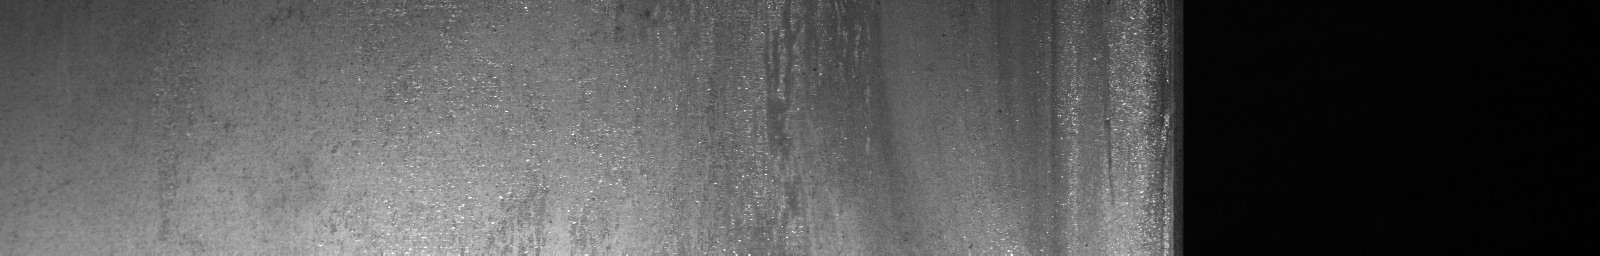

In [382]:
train_img.apply_tfms(get_extra_transforms()[0][0])

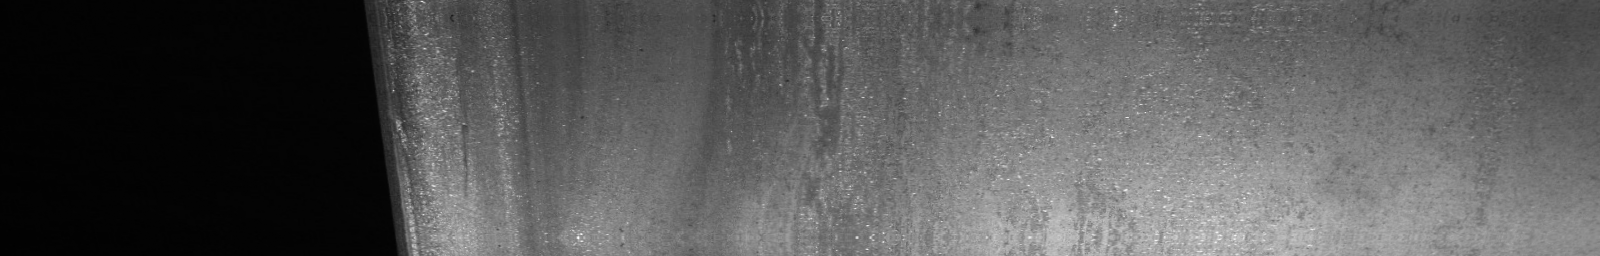

In [386]:
train_img.apply_tfms(get_extra_transforms()[0][1])

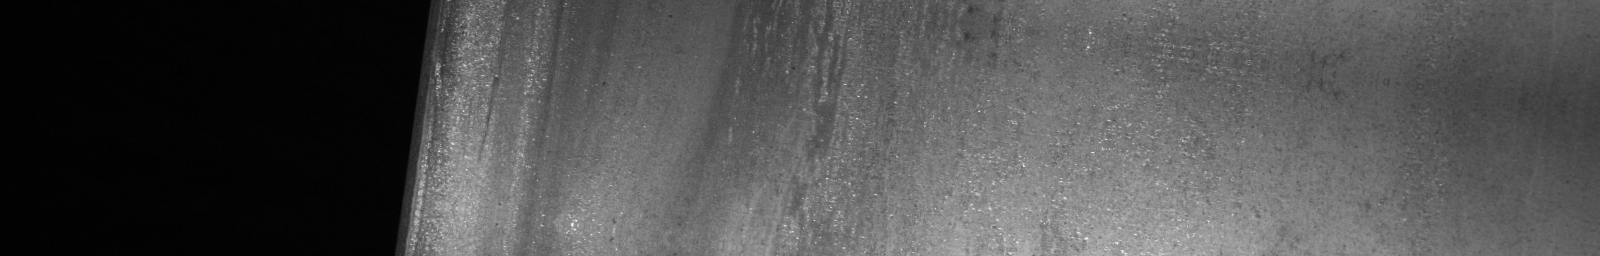

In [393]:
train_img.apply_tfms(get_extra_transforms()[0][2])

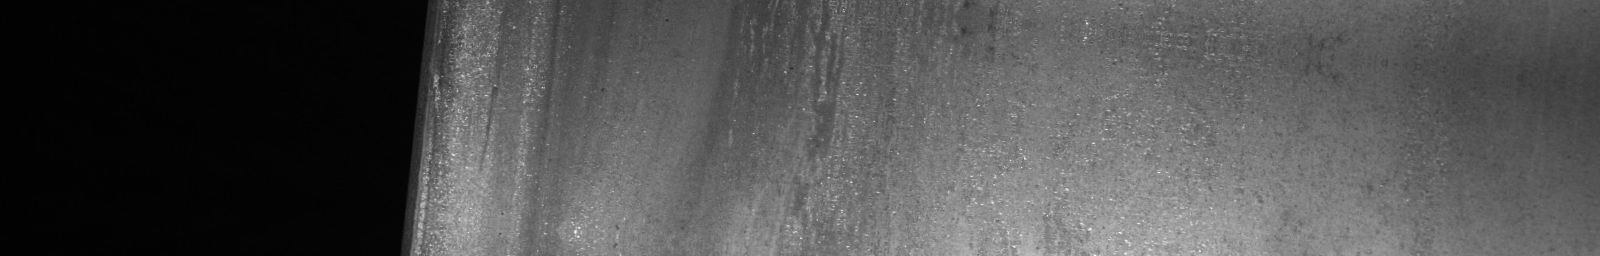

In [402]:
train_img.apply_tfms(get_extra_transforms()[0][3])

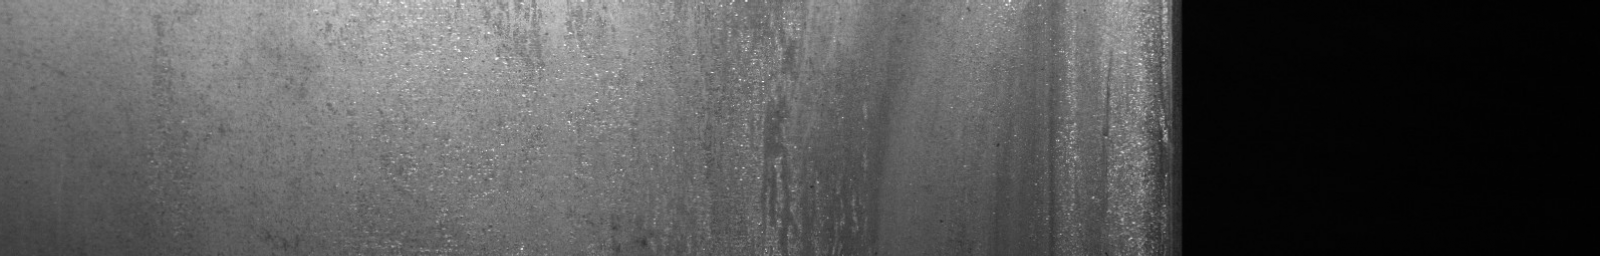

In [263]:
train_img.apply_tfms(get_extra_transforms()[0][4])

In [401]:
train_img.apply_tfms(get_extra_transforms()[0][5])

TypeError: uniform_int() missing 2 required positional arguments: 'low' and 'high'

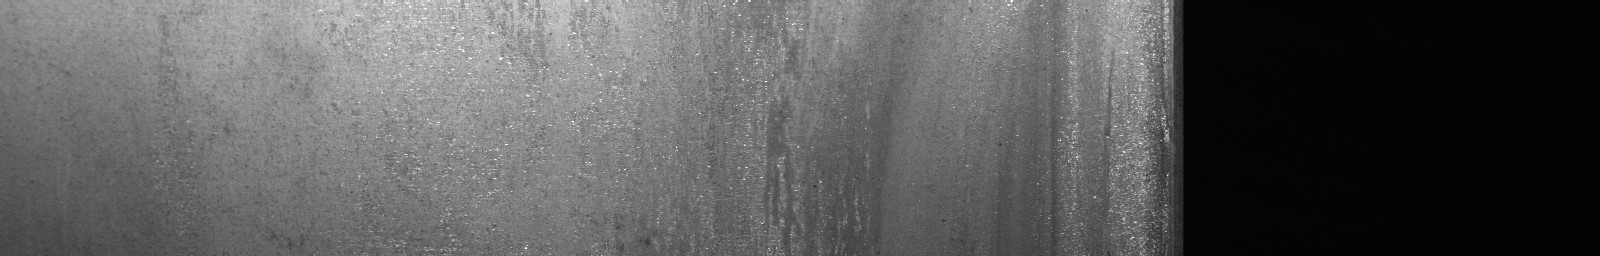

In [265]:
train_img.apply_tfms(get_extra_transforms()[0][6])

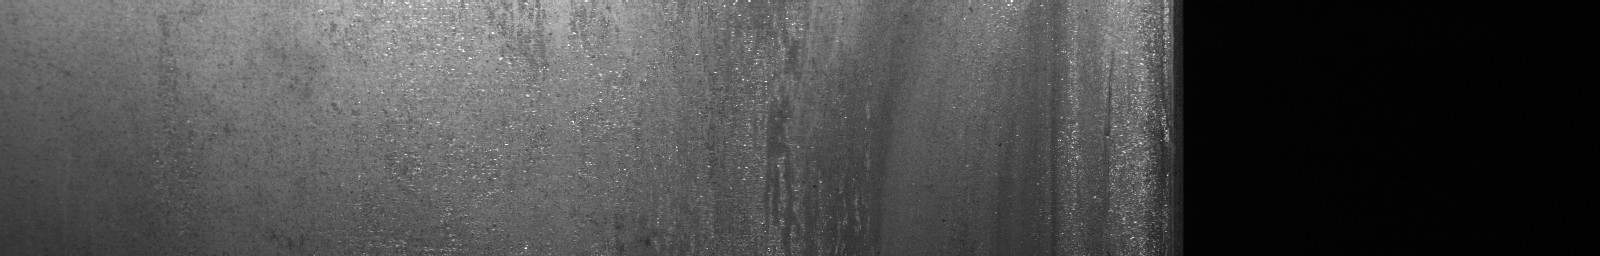

In [266]:
train_img.apply_tfms(get_extra_transforms()[0][7])

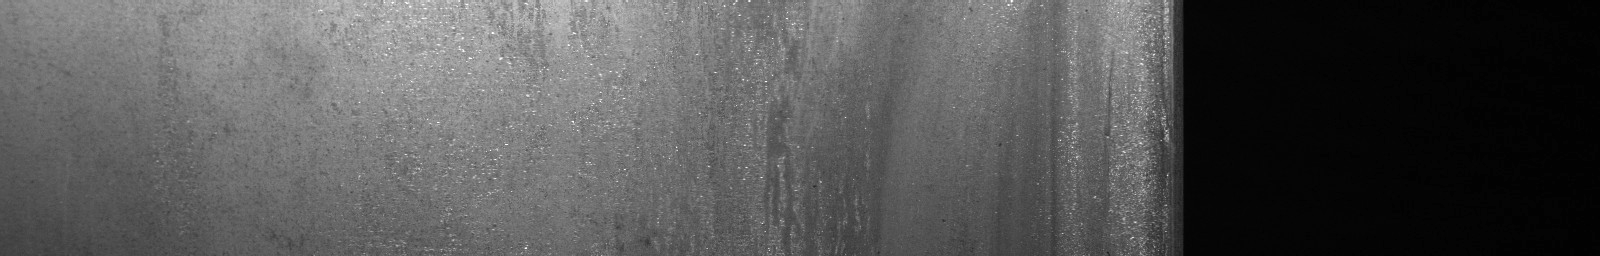

In [267]:
train_img.apply_tfms(get_extra_transforms()[0][8])

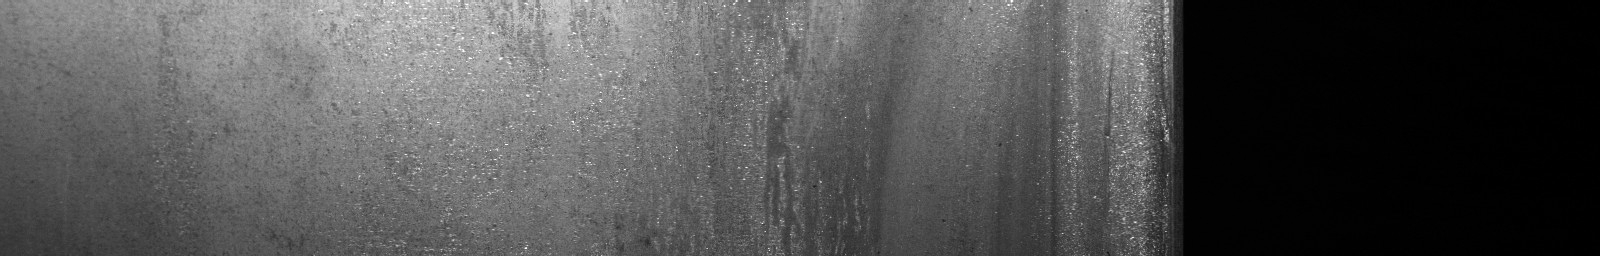

In [268]:
train_img.apply_tfms(get_extra_transforms()[0][9])

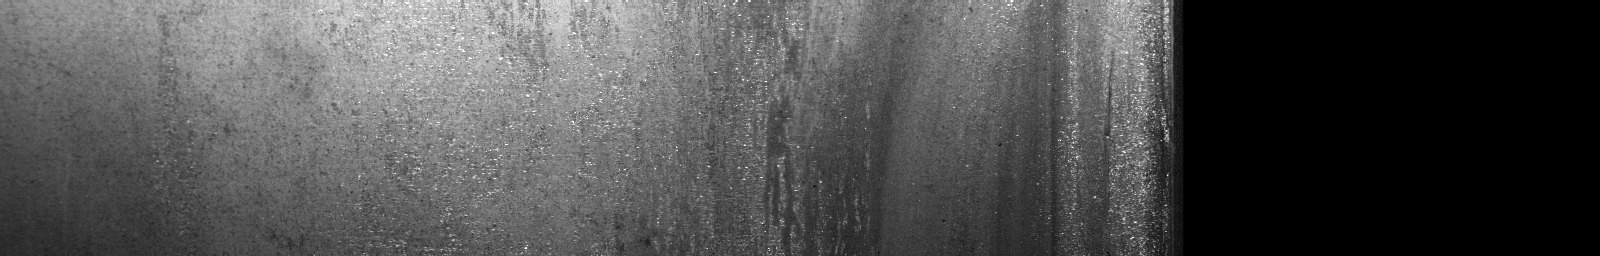

In [269]:
train_img.apply_tfms(get_extra_transforms()[0][10])

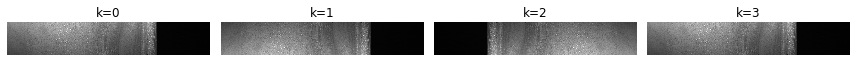

In [12]:
fig, axs = plt.subplots(1,4,figsize=(12,8))
for k, ax in enumerate(axs.flatten()):
    dihedral(train_img, k).show(ax=ax, title=f'k={k}')
plt.tight_layout()

In [37]:
src_size = np.array(open_image(str(train_images[0])).shape[1:])
src_size
valid_pct = 0.10

In [32]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [33]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [46]:
codes = array(['0', '1', '2', '3', '4'])
bs =  2

In [85]:
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=valid_pct)
       .label_from_func(get_y_fn, classes=codes))

In [86]:
data = (src.transform(([dihedral_affine()],[dihedral_affine()]), size=src_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

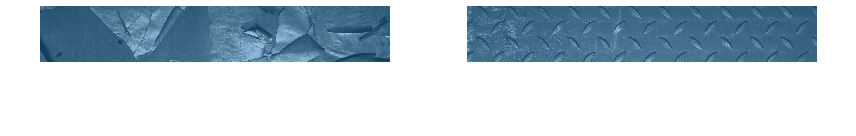

In [87]:
data.show_batch(rows=3, figsize=(12,2))